# 2D Beamformer
An exploration of 2d beamformer theory

In [1]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

import sys
import os
import numpy as np
from time import time
try:
    from multiprocessing import Pool, RawArray
    from contextlib import closing
    import multiprocessing as mp
    multiproc = 1
    print("Using Multiprocessing")
except:
    multiproc = 0
    print("NO Multiprocessing")

cwd = os.path.abspath(".")
if ("sandbox" in cwd):
    os.chdir(os.path.abspath(".."))
    cwd = os.path.abspath(".")

print ("CWD = " + cwd)
sys.path.append(cwd + "/bin")


# matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using Multiprocessing
CWD = /mnt/f/Documents/Caltech/DSA/DSAbeamformer


### Create array containing positions of antennas

Antennas can be distributed linearly, randomly, or a mix of both

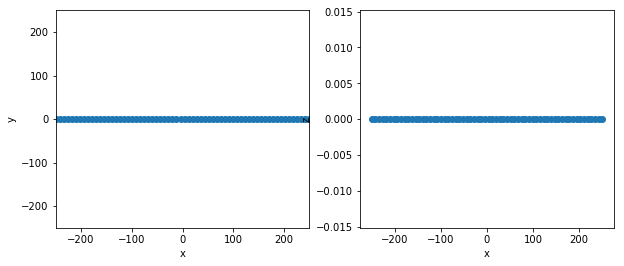

In [2]:
N = 64
max_pos = 250
Antenna_positions = 'Linear'

pos = np.zeros((N,3))

if Antenna_positions == 'Grid':
    x = np.linspace(-max_pos,max_pos,int(np.floor(np.sqrt(N))))
    y = np.linspace(-max_pos,max_pos,int(np.floor(np.sqrt(N))))

    xv, yv = np.meshgrid(x,y)
    pos[:,0] = xv.ravel()
    pos[:,1] = yv.ravel()
    pos[:,2] = 0
elif Antenna_positions == 'Linear':
    pos[:,0] = np.linspace(-max_pos,max_pos, N)
    pos[:,1] = 0
    pos[:,2] = 0 #np.random.uniform(size=(N)) - 1
elif Antenna_positions == 'Random':
    pos[:,0] = 2*max_pos*np.random.uniform(size=(N)) - max_pos
    pos[:,1] = 2*max_pos*np.random.uniform(size=(N)) - max_pos
    pos[:,2] = np.random.uniform(size=(N)) - 1
elif Antenna_positions == 'Linear with Random':
    pos = np.linspace(-max_pos,max_pos,N)
    pos[0] = np.random.uniform(-max_pos,max_pos)
    pos[1] = np.random.uniform(-max_pos,max_pos)
    pos[2] = np.random.uniform(-max_pos,max_pos)

fig = plt.figure(figsize= (10,4))

ax = plt.subplot(121)
ax2 = plt.subplot(122)
ax.scatter(pos[:,0], pos[:,1])
ax.set_xlim([-max_pos, max_pos])
ax.set_ylim([-max_pos, max_pos])
ax.set_xlabel("x")
ax.set_ylabel("y")

ax2.scatter(pos[:,0], pos[:,2])
ax2.set_xlabel("x")
ax2.set_ylabel("z")

plt.show()

### Create Fourier coefficient matrix

In [3]:
c = 299792458.0
zero_pt = 0              # Can be used if the first few channels have been flagged
gpu = 0                  # Determines the bandwidth in any gpu
tot_channels = 2048
n_gpus = 8               # Number of GPUs in system
bw_per_channel = (1.53 - 1.28)/tot_channels
N_BEAMS = 256
N_FREQ = tot_channels / n_gpus


field_of_view_half_angle = 3.5

if Antenna_positions != "Linear":
    ang = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, int(np.sqrt(N_BEAMS))) #beam angles

    T, P = np.meshgrid(ang, ang)

    theta = T.ravel()
    phi = P.ravel()
else:
    theta = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, N_BEAMS) #beam angles
    phi = np.zeros(len(theta))

# print theta

freq = [1.53 - (zero_pt + gpu * tot_channels/(n_gpus-1) + i)* bw_per_channel for i in range(N_FREQ)]

form_beams_with_freq = range(256)
n_freq = len(form_beams_with_freq)


'''
Calculate the fourier coefficients

Note we use np.round so that each number is ~ an 8-bit integer
'''

def assign_fourier_coefficients(tup):
    k, f = tup
    wavelength = c/(freq[f]*1e9)
    for i in range(N_BEAMS):
        for j in range(N):
            val = np.round(127.0*np.exp(-2.0j*np.pi*(pos[j,0]*np.sin(theta[i]) + pos[j,1]*np.sin(phi[i])) /wavelength))/127.0
            arr[2*(k*N_BEAMS*N + i*N + j)] = np.real(val)
            arr[2*(k*N_BEAMS*N + i*N + j)+1] = np.imag(val)
#             print arr[2*(k*N_BEAMS*N + i*N + j)]

print("Running")

if multiproc:
    t = time()
    print("Make Array")
    arr = RawArray('d', 2*n_freq * N_BEAMS * N)
    print("Starting")
    pool = Pool()
    pool.map(assign_fourier_coefficients, [(k, f) for k, f in enumerate(form_beams_with_freq)])
    pool.close()
    print("Done")

    a = np.frombuffer(arr, dtype=np.complex)
    A = np.reshape(a, (n_freq, N_BEAMS, N))
else:
    t = time()
    A = np.zeros((len(form_beams_with_freq), N_BEAMS, N), dtype=np.complex64) # Allocate space
    for k, f in enumerate(form_beams_with_freq):
        print(str(f) + ","),
        wavelength = c/(freq[f]*1e9)     
        for i in range(N_BEAMS):
            for j in range(N):
                A[k, i,j] = np.round(127.0*np.exp(-2.0j*np.pi*(pos[j,0]*np.sin(theta[i]) + pos[j,1]*np.sin(phi[i])) /wavelength))/127.0

print("total time: " + str(time()-t))

Running
Make Array
Starting
Done
total time: 8.95724511147


In [4]:
np.sum(A)

(13295.149606299225+0j)

### Generate the test signals

In [5]:
if Antenna_positions == "Linear":
    eval_pts = 1024 #number of test signals
    angles = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, eval_pts)
    T_angles = angles
    P_angles = np.zeros(eval_pts)
else:
    eval_pts = 3721 #number of test signals
    angles = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, int(np.sqrt(eval_pts)))
    t, p = np.meshgrid(angles,angles)    
    T_angles = t.ravel()
    P_angles = p.ravel()
    
N_AVERAGING = 1
file_name = "2d_pydata_na_%d_eval_%d_N_%d_%s"% (N_AVERAGING, eval_pts, N, Antenna_positions)
print(file_name)

n_angles = len(T_angles)

def generate_signal(angle):
    print(str(angle) + ", "),
    for k, f in enumerate(form_beams_with_freq):
        wavelength = c/(freq[f]*1e9)
        signal = [np.round(7*np.exp(2*np.pi*1j*(pos[i,0]*np.sin(T_angles[angle]) + pos[i,1]*np.sin(P_angles[angle]))/wavelength)) for i in range(N)]
        out_arr[angle*N_BEAMS:(angle+1)*N_BEAMS] += 2*N_AVERAGING*np.abs(np.dot(A[k,:,:], signal))**2

        
try:
#     throw("error")
    out = np.load("bin/" + file_name + ".npy")
    print("Loading from Memory: " + file_name)
except:
    out = np.zeros((N_BEAMS, eval_pts))

    '''
    Note we use np.round so that each number is ~ an 4-bit integer

    This loop can take a while to calculate
    '''
    if multiproc:
        t = time()
        out_arr = RawArray('d', N_BEAMS*n_angles)
        pool = Pool()
        pool.map(generate_signal, range(n_angles))
        pool.close()
        
        a = np.frombuffer(out_arr, dtype=np.complex)
        out = np.reshape(a, (n_angles, N_BEAMS))
    else:
        t = time()
        for k, f in enumerate(form_beams_with_freq):
            print(str(k) + ","),
            wavelength = c/(freq[f]*1e9)
            for jj in range(n_angles):
                signal = [np.round(7*np.exp(2*np.pi*1j*(pos[i,0]*np.sin(T_angles[jj]) + pos[i,1]*np.sin(P_angles[jj]))/wavelength)) for i in range(N)]
                out[:,jj] += 2*N_AVERAGING*np.abs(np.dot(A[k,:,:], signal))**2

            
                
    print("Time = {}".format(time()-t))
    np.save("bin/" + file_name, out)
    print("\nSaving to Memory: " + file_name)

2d_pydata_na_1_eval_1024_N_64_Linear
Loading from Memory: 2d_pydata_na_1_eval_1024_N_64_Linear


#### Plot beams patterns over top of eachother

In [ ]:
# mpld3.disable_notebook()
%matplotlib tk

'''
Change "eval_pts" if more resolution is desired
'''

fig = plt.figure(figsize=(10,4))
fig.suptitle(Antenna_positions + " Locations")
ax = plt.subplot(121,projection='polar')
ax2 = plt.subplot(122)

for jj in range(256):
    ax.plot(angles, np.real(out[jj]))
    ax2.plot(angles*180/np.pi, np.real(out[jj]))
    
ax2.axis([-3.6, -3.4, -100, 2.0*max(out[0])])
ax2.set_xlabel("Angle [deg]")
ax2.set_ylabel("Response Amplitude")

plt.show()
# mpld3.enable_notebook()

#### Plot Fourier coefficient matricies for 4 frequencies

In [ ]:
fig = plt.figure(figsize= (8,4))
tr = 141
for k in range(4):
    ax = plt.subplot(tr)
    tr+=1
    ax.imshow(np.real(A[k]))
    if (k == 0):
        ax.set_ylabel("Beam number")
        ax.set_xlabel("antennas")
    ax.set_title("Freq = {0:.4g}".format(freq[form_beams_with_freq[k]]))


plt.show()

In [ ]:
'''
Plot Intensity as a function of source direction and beam number (2d plot)
'''
%matplotlib tk
fig = plt.figure(figsize= (10,4))
plt.imshow(da)
plt.show()

In [ ]:
%matplotlib tk
fig = plt.figure(figsize= (10,4))
plt.imshow(out.T)
plt.show()

In [ ]:
plt.scatter(T_angles, P_angles, label = "Source Locations")
plt.scatter(theta, phi, label = "Beam Locations")
plt.legend()
plt.show()

## GPU Validation

This block compares the GPU implementation with the python implementation for a demonstration of correctness.
The GPU code exports a file called data.py which is stored in bin/. This code reads in that file and compares
it to the calculations made previously.

Note that to be accurate, N_AVERAGING, N_BEAMS, N_FREQS, etc. have to be the same for both implementations.

reloading the data
Size = 3721


ValueError: operands could not be broadcast together with shapes (1024,256) (3721,256) 

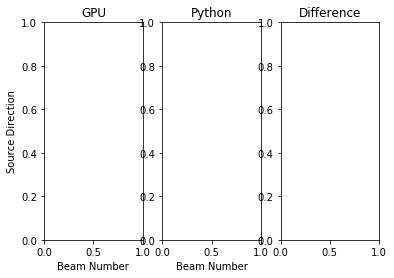

In [7]:
# import os, sys
# print sys.path
try:
    reload(data)
    print("reloading the data")
except:
    import data
    print("importing the data")

print("Size = {}".format(len(data.A)))
da = np.array(data.A)

vmx = max(np.max(da), np.max(out)) #determines scale

#Plot GPU image
ax = plt.subplot(131)
ax.set_title("GPU")
ax.set_ylabel("Source Direction")
ax.set_xlabel("Beam Number")

#plot Python image
ax2 = plt.subplot(132)
ax2.set_title("Python")
ax2.set_xlabel("Beam Number")
# ax2.colorbar()

#plot percent difference image
ax3 = plt.subplot(133)
ax3.set_title("Difference")
b = np.abs((out.T - da)/out.T)
plt.suptitle("Beamformer Validation")
ax3.set_xlabel("Beam Number")

im = ax.imshow(da, vmin = 0, vmax = vmx, aspect = 'auto')
im2 = ax2.imshow(out.T, vmin = 0, vmax = vmx, aspect = 'auto')
im3 = ax3.imshow(b*100, vmin = 0, vmax = 1, aspect = 'auto')

fig.colorbar(im2, ax = ax2)
fig.colorbar(im3, ax = ax3)

plt.show()
print(np.sqrt(np.sum(b**2)/(1024*256)))
print(np.mean(b)*100)

## Histograms

Plot histograms of both images and errors

In [ ]:
ax = plt.subplot(121)
ax2 = plt.subplot(122)
_, bi, _ = ax.hist(x = np.log10(out.ravel()), bins=20, alpha = .7, log = True, label =  "Python")
ax.hist(x = np.log10(da.ravel()), bins=bi, alpha = .7, log = True, label = "GPU")
ax.set_title("Python vs GPU Image Histograms")
ax.set_xlabel("$\log_{10}$(Pixel Intensity)")
ax.legend()

ax2.hist(x = (b*100).ravel(), bins=20, alpha = .7, log = True)
ax2.set_title("Errors")
ax2.set_xlabel("% error")

plt.suptitle("Comparison of Beamformer Results")
plt.show()